### apriltags and poses 20250116 CJH
* intended to teach the basics of apriltags and pose updates
* using https://www.chiefdelphi.com/t/wpilib-apriltagdetector-sample-code/421411/44?page=3 as a template for the geometry

In [5]:
import robotpy_apriltag as ra  # this comes with the robotpy package, you may need to add apriltags to the project.toml and sync to get it
import matplotlib.pyplot as plt  # you always need matplotlib
import cv2
import numpy as np
import pandas as pd
import wpimath.geometry as geo
from wpimath import objectToRobotPose
import time

#### get yourself a layout of tags you can query for poses

In [6]:
# this is how you load in a layout - different in 2025 from 2024
field = ra.AprilTagField.k2025ReefscapeWelded
# layout = ra.loadAprilTagLayoutField(field=field)  # old way
layout = ra.AprilTagFieldLayout.loadField(field)

In [7]:
# example calls
tag = layout.getTags()[0]
tag.pose.x, tag.pose.translation(), tag.pose.rotation()

(16.697198,
 Translation3d(x=16.697198, y=0.655320, z=1.485900),
 Rotation3d(x=0.000000, y=0.000000, z=2.199115))

In [8]:
tag.pose, tag.pose.toPose2d()

(Pose3d(Translation3d(x=16.697198, y=0.655320, z=1.485900), Rotation3d(x=0.000000, y=0.000000, z=2.199115)),
 Pose2d(Translation2d(x=16.697198, y=0.655320), Rotation2d(2.199115)))

In [9]:
# let's see them all - remember rotations are in radians, 0 faces to the right, CCW is positive, so #6 is at -pi/2
tag_layout = {} 
for tag in layout.getTags():
    # print (f'ID:{tag.ID:02d}  pose: {tag.pose}')
    tag_layout.update({tag.ID:{'ID':tag.ID, 'X':tag.pose.x, 'Y':tag.pose.y, 'Z':tag.pose.z, 'Z_DEG':tag.pose.rotation().z*180/3.1459,
                              'X_ROT':tag.pose.rotation().x, 'Y_ROT':tag.pose.rotation().x, 'Z_ROT':tag.pose.rotation().z,}})
df = pd.DataFrame(tag_layout).transpose()
df

,ID,X,Y,Z,Z_DEG,X_ROT,Y_ROT,Z_ROT
1,1.0,16.697198,0.655320,1.485900,125.827482,0.0,0.0,2.199115
2,2.0,16.697198,7.396480,1.485900,-125.827482,0.0,0.0,-2.199115
3,3.0,11.560810,8.055610,1.301750,-89.876773,0.0,0.0,-1.570796
4,4.0,9.276080,6.137656,1.867916,0.000000,0.0,0.0,0.000000
5,5.0,9.276080,1.914906,1.867916,0.000000,0.0,0.0,0.000000
6,6.0,13.474446,3.306318,0.308102,-59.917848,0.0,0.0,-1.047198
7,7.0,13.890498,4.025900,0.308102,0.000000,0.0,0.0,0.000000
8,8.0,13.474446,4.745482,0.308102,59.917848,0.0,0.0,1.047198
9,9.0,12.643358,4.745482,0.308102,119.835697,0.0,0.0,2.094395
10,10.0,12.227306,4.025900,0.308102,179.753545,0.0,0.0,3.141593


#### plot of the apriltag locations in reefscape 

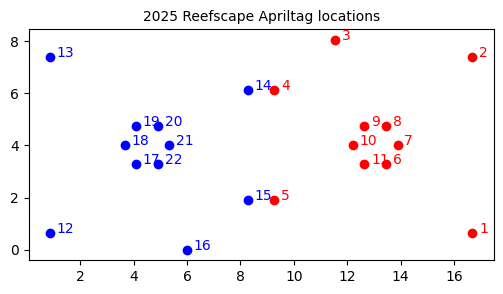

In [11]:
# make a quick plot of the locations of each tag
fig, ax = plt.subplots(1,1,figsize = (6,3))
for field_tag in layout.getTags():
    color = 'r' if field_tag.ID < 12 else 'b'
    ax.scatter(field_tag.pose.x, field_tag.pose.y, c=color)
    ax.text(field_tag.pose.x + 0.25, field_tag.pose.y, str(field_tag.ID), c=color)
ax.set_title('2025 Reefscape Apriltag locations', fontsize=10);

In [12]:
# if you want a tag's pose, just ask for it by ID
layout.getTagPose(6)

Pose3d(Translation3d(x=13.474446, y=3.306318, z=0.308102), Rotation3d(x=0.000000, y=-0.000000, z=-1.047198))

#### set up an apriltag detector and a pose estimator

In [13]:
# set up an apriltag detector
camera = 'c920'
detector = ra.AprilTagDetector()
qt = detector.getQuadThresholdParameters()
qt.minClusterPixels = 10
detector.setQuadThresholdParameters(qt)

f = detector.addFamily('tag36h11')
print(f)
# need to calculate this based on camera and resolution
if camera == 'lifecam':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1524, fx=342.3, fy=335.1, cx=320/2, cy=240/2)
elif camera == 'c920':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1524, fx=439.5, fy=439.9, cx=640/2, cy=360/2) # logitech at 640x360
else:
    raise ValueError('invalid camera')
estimator = ra.AprilTagPoseEstimator(config)  # 6 inches is 0.15m

True


#### read an image and extract the pose from the camera to the tag

In [112]:
image = cv2.imread('cal_images/test2.jpg', cv2.COLOR_RGB2BGR)
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [68]:
print(grey_image.min(), grey_image.max())
print(grey_image.shape)

33 255
(480, 640)


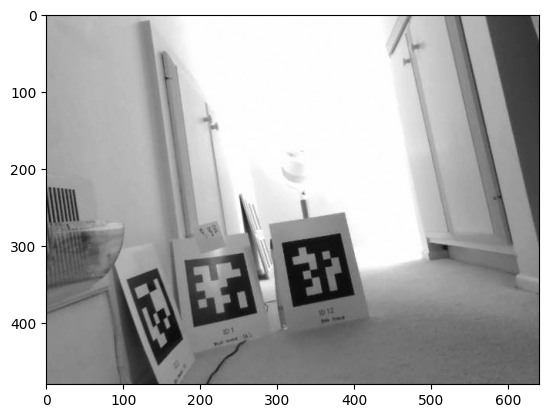

In [53]:
plt.imshow(grey_image, cmap='gray')

#### struggle but finally figure out how to modify a detector Config and QuadThresholdParameters

In [71]:
cfg = detector.getConfig()
properties = ['debug', 'decodeSharpening',  'numThreads',  'quadDecimate',  'quadSigma',  'refineEdges']
for prop in properties:
    value = getattr(cfg, prop)  # Or: value = cfg.prop (if you know it exists)
    print(f"{prop}: {value}")

debug: False
decodeSharpening: 0.25
numThreads: 8
quadDecimate: 2.0
quadSigma: 0.0
refineEdges: True


In [72]:
qt = detector.getQuadThresholdParameters()
properties = ['criticalAngle',
 'deglitch',
 'maxLineFitMSE',
 'maxNumMaxima',
 'minClusterPixels',
 'minWhiteBlackDiff']
for prop in properties:
    value = getattr(qt, prop)  # Or: value = cfg.prop (if you know it exists)
    print(f"{prop}: {value}")

criticalAngle: 0.7853981633974483
deglitch: False
maxLineFitMSE: 10.0
maxNumMaxima: 10
minClusterPixels: 10
minWhiteBlackDiff: 5


In [93]:
cfg.numThreads = 8  # can give a big speed up
cfg.debug = False  # how does this give me more info?
cfg.quadDecimate = 1  # big speed and detection effect - i think 0 and one are off, then about a 4x speed up if you go to 4 but you lose tags
cfg.decodeSharpening = 1  # drops the margin as this goes down
cfg.quadSigma = 0
cfg.refineEdges = True
detector.setConfig(cfg)

In [94]:
start_time = time.time()
iterations = 100
for i in range(iterations):
    tags = detector.detect(grey_image, )
end_time = time.time()
print(f'detections took {1000*(end_time-start_time)/iterations:.1f} ms each')
# tags = [tag for tag in tags if tag.getHamming()< 2 and tag.getDecisionMargin() > 20]
tags

detections took 13.6 ms each


[<AprilTagDetection tag_family=tag36h11 tag_id=1 hamming=0 decision_margin=190.60107421875 center=AprilTagDetection.Point(x=227.10810296654557, y=353.992157920839)>,
 <AprilTagDetection tag_family=tag36h11 tag_id=3 hamming=0 decision_margin=221.77108764648438 center=AprilTagDetection.Point(x=144.84327942654306, y=386.75193870390825)>,
 <AprilTagDetection tag_family=tag36h11 tag_id=12 hamming=0 decision_margin=225.41366577148438 center=AprilTagDetection.Point(x=352.8413348215964, y=330.20936131394075)>]

In [95]:
# not much I can do with this matrix
print(tags[0].getHomography())

(50.57449816499397, -2.6341874991840277, 227.10810296654557, 10.091415460067816, 24.92258771885685, 353.992157920839, 0.04775975829633085, -0.045041081575350264, 1.0)


#### if you want the ambiguity (and you do!) you have to use estimateOrthogonalIteration instead of estimate

In [167]:
at_poses = [estimator.estimateOrthogonalIteration(tag, 50) for tag in tags]

In [168]:
dmesg = ''
for tag, at_pose in zip(tags, at_poses):
    msg = f'ID {tag.getId():2d} ambiguity: {at_pose.getAmbiguity()}' + '\n' + f'{at_pose.pose1}' + '\n' + f'{at_pose.pose2}:'
    for d in ['x','y','z']:
        d = np.degrees (getattr(at_pose.pose1.rotation(), d) - getattr(at_pose.pose2.rotation(), d))
        dmesg = dmesg + f'{d:.2f} '
    print(msg)
    #print(dmesg)

ID  1 ambiguity: 0.01846742217210126
Transform3d(Translation3d(x=-0.172579, y=0.322411, z=0.816276), Rotation3d(x=-0.694427, y=-0.542418, z=0.041401))
Transform3d(Translation3d(x=-0.176225, y=0.327331, z=0.818470), Rotation3d(x=-0.069267, y=0.032639, z=-0.193623)):
ID  3 ambiguity: 0.008403901961287976
Transform3d(Translation3d(x=-0.257850, y=0.302220, z=0.646547), Rotation3d(x=-2.173682, y=-1.353479, z=1.737324))
Transform3d(Translation3d(x=-0.255306, y=0.295586, z=0.626958), Rotation3d(x=-0.349221, y=0.648820, z=-0.721940)):
ID 12 ambiguity: 0.0
Transform3d(Translation3d(x=0.062694, y=0.287872, z=0.843656), Rotation3d(x=-0.382948, y=-0.139540, z=-0.136304))
Transform3d(Translation3d(x=0.000000, y=0.000000, z=0.000000), Rotation3d(x=0.000000, y=0.000000, z=0.000000)):


In [118]:
poses = [estimator.estimate(tag) for tag in tags]

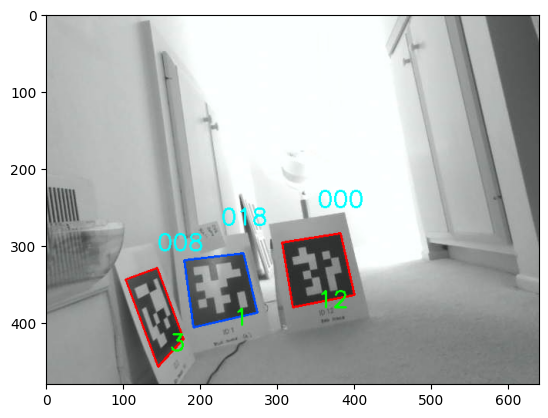

In [146]:
# see that we have the right one, and show the ambiguity
cvimage = image.copy()
for tag in tags:
    color = (255, 75, 0) if tag.getId() in [1, 2, 6, 7, 8, 14, 15, 16] else (0, 0, 255)  # blue and red tags - opencv is BGR
    center = tag.getCenter()
    center = [int(center.x), int(center.y)]
    corners = np.array(tag.getCorners([0] * 8)).reshape((-1, 1, 2)).astype(dtype=np.int32)
    cvimage = cv2.polylines(cvimage, [corners], isClosed=True, color=color, thickness=2)

    a = estimator.estimateOrthogonalIteration(tag, 50).getAmbiguity()
    cvimage = cv2.putText(cvimage, f'{int(1000*a):03d}', (center[0], center[1]-80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    cvimage = cv2.putText(cvimage, f'{tag.getId():2d}', (center[0], center[1]+50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cvimage, cv2.COLOR_BGR2RGB))

#### this is the pose of the camera relative to the tag - need to experiment a bit with positions to get it
* x (is negative if camera on right? or is this because we're twisted too?) - like a strafe 
* y is negative (because camera is below the tag?) - like a relative height
* z is distance so we should always be positive there 

In [147]:
pose = poses[0]
pose

Transform3d(Translation3d(x=-0.172579, y=0.322411, z=0.816276), Rotation3d(x=-0.694427, y=-0.542418, z=0.041401))

#### now we have to do some transforms to get the field pose of the camera, robot, and the tag

In [148]:
# camera is facing the tag, so we have to flip some things
pose_camera = geo.Transform3d(
    geo.Translation3d(pose.x, pose.y, pose.z),
    geo.Rotation3d(-pose.rotation().x -np.pi, -pose.rotation().y, pose.rotation().z - np.pi)
)

In [149]:
pose, pose_camera

(Transform3d(Translation3d(x=-0.172579, y=0.322411, z=0.816276), Rotation3d(x=-0.694427, y=-0.542418, z=0.041401)),
 Transform3d(Translation3d(x=-0.172579, y=0.322411, z=0.816276), Rotation3d(x=-2.447166, y=0.542418, z=-3.100192)))

In [150]:
# OpenCV and WPILib estimator layout of axes is EDN and field WPILib is NWU; need x -> -y , y -> -z , z -> x and same for differential rotations
pose_nwu = geo.CoordinateSystem.convert(pose_camera, geo.CoordinateSystem.EDN(), geo.CoordinateSystem.NWU())
#print(pose_nwu)
# this may be buggy, according to OP, so try 
old = geo.CoordinateSystem.EDN()
new = geo.CoordinateSystem.NWU()
pose_nwu2 = geo.Transform3d(
    geo.CoordinateSystem.convert(pose_camera.translation(), old, new),
    geo.CoordinateSystem.convert(geo.Rotation3d(), new, old) + (geo.CoordinateSystem.convert(pose_camera.rotation(), old, new)),
)
#print(pose_nwu2)
# nope - they both give the same answer

In [151]:
# camera pointing forwards on robot, at front and 6" off the ground
camera_in_robot_frame = geo.Transform3d(geo.Translation3d(0.2, 0, 0.15), geo.Rotation3d(0, 0, 0))
camera_in_robot_frame

Transform3d(Translation3d(x=0.200000, y=0.000000, z=0.150000), Rotation3d(x=0.000000, y=0.000000, z=0.000000))

In [152]:
tag_in_field_frame = layout.getTagPose(tag.getId())
# tag_in_field_frame = layout.getTagPose(1)  # can play with where the robot shows up if you change this number

In [153]:
robot_in_field_frame = objectToRobotPose(tag_in_field_frame,  pose_nwu2,  camera_in_robot_frame);

In [154]:
print(f'pose: {pose}\npose_camera: {pose_camera}\npose_nwu: {pose_nwu}\ntag_in_field_frame: {tag_in_field_frame}\nrobot_in_field_frame: {robot_in_field_frame}')

pose: Transform3d(Translation3d(x=-0.172579, y=0.322411, z=0.816276), Rotation3d(x=-0.694427, y=-0.542418, z=0.041401))
pose_camera: Transform3d(Translation3d(x=-0.172579, y=0.322411, z=0.816276), Rotation3d(x=-2.447166, y=0.542418, z=-3.100192))
pose_nwu: Transform3d(Translation3d(x=0.816276, y=0.172579, z=-0.322411), Rotation3d(x=-0.045332, y=-0.672545, z=-2.570543))
tag_in_field_frame: Pose3d(Translation3d(x=0.851154, y=0.655320, z=1.485900), Rotation3d(x=0.000000, y=0.000000, z=0.942478))
robot_in_field_frame: Pose3d(Translation3d(x=1.660195, y=1.117201, z=1.012145), Rotation3d(x=0.364614, y=-0.580078, z=-2.864248))


#### now plot where the robot is on the field based on the tag
* note matplotlib and the pose have different definitions of zero

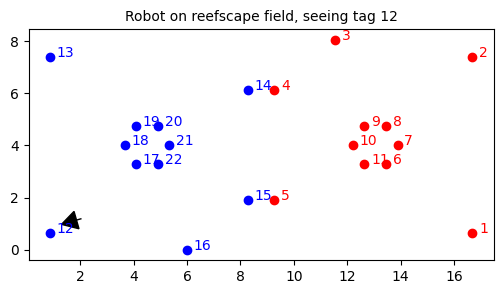

In [155]:
# make a quick plot of the locations of each tag
fig, ax = plt.subplots(1,1,figsize = (6,3))
for field_tag in layout.getTags():
    color = 'r' if field_tag.ID < 12 else 'b'
    ax.scatter(field_tag.pose.x, field_tag.pose.y, c=color)
    ax.text(field_tag.pose.x + 0.25, field_tag.pose.y, str(field_tag.ID), c=color)
# show the robot as a triangle - looks like CCW is positive
rotation = -90 + np.rad2deg(robot_in_field_frame.rotation().z)  # matplotlib angle of the triangle is 0 up, robot is 0 right
ax.plot(robot_in_field_frame.x, robot_in_field_frame.y, marker=(3, 0, rotation), color='k', markersize=15, linestyle='None')
ax.plot(robot_in_field_frame.x, robot_in_field_frame.y, marker=(2, 0, rotation), color='k', markersize=15, linestyle='None')
ax.set_title(f'Robot on reefscape field, seeing tag {tag.getId()}', fontsize=10);

In [166]:
# mucking about with compression
# compression = 1
# fig, axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# axs[0].set_title(f'original image: {image.size}')
# ret, im_compressed = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 10])
# axs[1].imshow(cv2.cvtColor(cv2.imdecode(im_compressed, 1),cv2.COLOR_BGR2RGB))
# axs[1].set_title(f'compressed image: {im_compressed.size}')

#### find the closest stage (or whatever)

In [158]:
import robotpy_apriltag as ra  # this comes with the robotpy package, you may need to add apriltags to the project.toml and sync to get it
import wpimath.geometry as geo

In [159]:
# this is how you load in a layout
field = ra.AprilTagField.k2025ReefscapeWelded
layout = layout = ra.AprilTagFieldLayout.loadField(field)

In [160]:
# make up a pose - irl would be the pose of the robot
x = 15
y = 6
my_location = geo.Pose2d(geo.Translation2d(x,y), geo.Rotation2d(0))

In [161]:
# get the tags
stage_tags = [11,12,15,16]
stage_poses = [layout.getTagPose(tag).toPose2d() for tag in stage_tags]

In [162]:
# find the tag distances
distances = [my_location.translation().distance(pose.translation()) for pose in stage_poses]
distances

[3.5790619208513292, 15.124663547798875, 7.870852370030835, 10.829133562656986]

In [163]:
# sort the tags based on the distances to them
combined = list(zip(stage_tags, distances))
combined.sort(key=lambda x: x[1])
sorted_tags, sorted_distances = zip(*combined)
print("Sorted tags:", sorted_tags)
print("Sorted distances:", sorted_distances)

Sorted tags: (11, 15, 16, 12)
Sorted distances: (3.5790619208513292, 7.870852370030835, 10.829133562656986, 15.124663547798875)


In [164]:
# winner is sorted_tags[0]
sorted_tags[0]

11